# Figure 5

H. Sanchez & F. Palmero @ Nynke Dekker Lab

In [1]:
# Imports
import os
import yaml
import scipy
import pickle
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.stats.proportion
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings("ignore")

## Parameters

In [2]:
# DNA information
dna_length = 10.439         # kbp
origin = 6.896              # kbp location of the origin of replication
NPS1 = 6.750                # kbp location of the first nucleosome position sequence
NPS2 = 7.04                 # kbp location of the second nucleosome position sequence
locs_from_center = [ dna_length/2 - origin]  # Locations from center in kbp.

# Location bins; origin should be in third bin
binwidth = (origin - dna_length/2) / 2.5

## Functions

In [3]:
def plot_location_histogram(NN, fig, ax, bandw, cut_v, lw, color_s, binwidth,
                            data, color='gray', edgecolor='k', ylim=0.3, filename=None, vlines=[]):
    """Generate location histogram figure."""

    # Config axis
    ax2 = ax.twinx()
    ax.set_ylim((0, 1.1))
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1])

    ax2.set_ylim(0, ax.get_ylim()[1] / binwidth)
    ax2.set_yticks([0.0, 0.5, 1, 1.5])
    ax2.axvline(x=locs_from_center, color='k', linestyle='--', zorder=100)

    ax2.set_ylabel(f'PDF (1/kbp)', color='#de59d7', rotation=270, labelpad=22,
                       path_effects=[pe.withStroke(linewidth=2, foreground='black', capstyle="round")])

    ax.set_ylabel('Fraction')
    ax.set_xlabel("kbp from DNA center")

    plt.xlim((0, binwidth*len(data['bins'])))
    plt.xticks([0, 1, 2, 3, 4, 5])
    plt.xlabel('kbp from DNA center')

    # Plot histogram.
    ax.bar(data['bins'], data['values'], align='center', width=data['bin_width'], color=color, edgecolor=edgecolor)

    plt.annotate("$N_{scans}$ = " + str(NN), xy=(0.99, 0.98),
                 xycoords='axes fraction', horizontalalignment='right', verticalalignment='top')
    plt.annotate("$N_{foci}$ = " + str(len(data['locs_all'])), xy=(0.99, 0.85),
                 xycoords='axes fraction', horizontalalignment='right', verticalalignment='top')

    for x in vlines:
        plt.axvline(x, linestyle='dashed', color='k')

    # Include density plot
    sns.kdeplot(data['locs_all'], bw_method=bandw, cut=cut_v, linewidth= 2,
                    color='#de59d7', path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()],
                     ax=ax2, zorder=99);

    # Cleanup.
    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(filename)
    return fig

def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)


def count_non_empty(df_in, chromatin_color='b'):
    """Count not empty scans."""
    exp_names = []
    for scan_id, df_scan in df_in.groupby('scan_id'):
        if (df_scan['color_str'] == chromatin_color).all():
            # only chromatin, do not count
            pass
        else:
            exp_names.append(df_scan['file_name'].iloc[0])
    return len(exp_names)

## Left Panel

In [4]:
# Figure b) i.
df_scans1 = pd.read_csv(os.path.join('figure_data', 'Figure 5', 'bi', 'scans_example.csv'))
NN1 = count_non_empty(df_scans1)

with open(os.path.join('figure_data', 'Figure 5', 'bi', 'datar00b5.yaml'), "r") as file:
    datar00b5 = yaml.safe_load(file)

# Figure b) ii.
df_scans2 = pd.read_csv(os.path.join('figure_data', 'Figure 5', 'bii', 'scans_example.csv'))
NN2 = count_non_empty(df_scans2)

with open(os.path.join('figure_data', 'Figure 5', 'bii', 'datar00b3.yaml'), "r") as file:
    datar00b3 = yaml.safe_load(file)

# Figure b) iii.
df_scans3 = pd.read_csv(os.path.join('figure_data', 'Figure 5', 'biii', 'scans_example.csv'))
NN3 = count_non_empty(df_scans3)

with open(os.path.join('figure_data', 'Figure 5', 'biii', 'datar00b29.yaml'), "r") as file:
    datar00b29 = yaml.safe_load(file)

# Figure b) iv.
df_scans4 = pd.read_csv(os.path.join('figure_data', 'Figure 5', 'biv', 'scans_example.csv'))
NN4 = count_non_empty(df_scans4)

with open(os.path.join('figure_data', 'Figure 5', 'biv', 'datar00b28.yaml'), "r") as file:
    datar00b28 = yaml.safe_load(file)

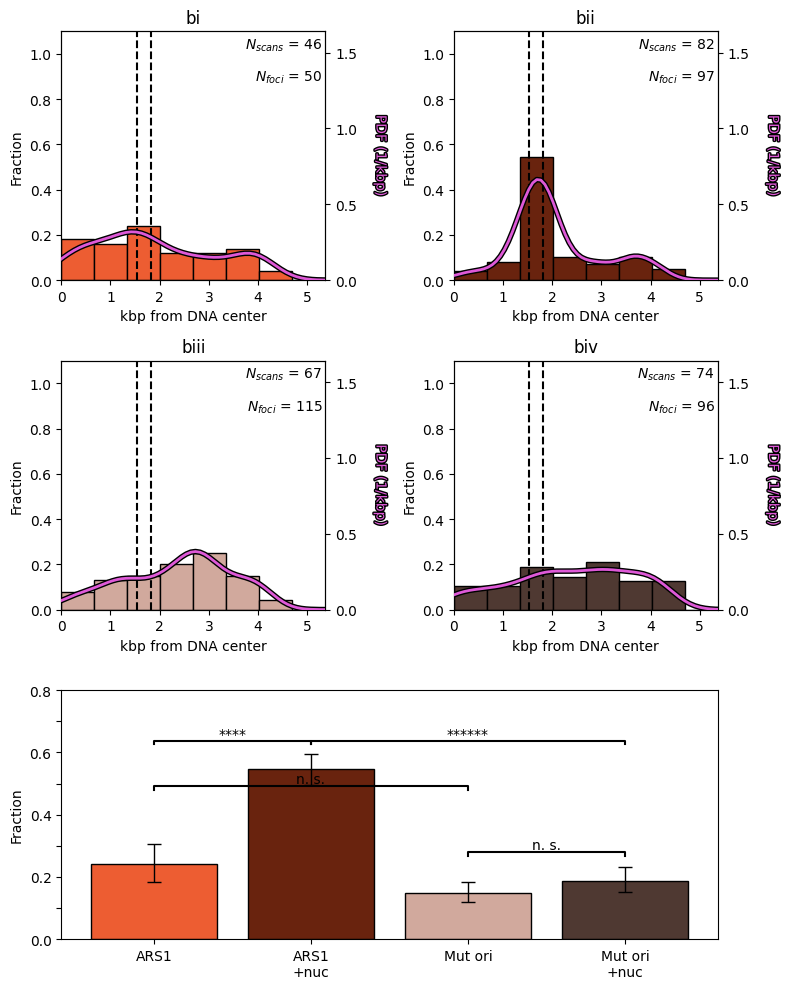

In [5]:
# Config plot parameters
bandw= binwidth/2
cut_v= 20
lw= 2
color_s= 'k'

# Create figure
fig = plt.figure(constrained_layout=True,figsize=(8, 10))
gs = fig.add_gridspec(3, 2)

# Figure b) i.
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('bi')
plot_location_histogram(NN1, fig, ax1, bandw, cut_v, lw, color_s, binwidth, datar00b5,  '#ed5d32', edgecolor='k',
        ylim=0.8, vlines=[abs (dna_length/2 - NPS1), abs (dna_length/2 - NPS2)])
ax1.set_xlabel("kbp from DNA center")

# Figure b) ii.
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('bii')
plot_location_histogram(NN2, fig, ax2, bandw, cut_v, lw, color_s, binwidth, datar00b3,   '#69230e' , edgecolor='k',
        ylim=0.8, vlines=[abs (dna_length/2 - NPS1), abs (dna_length/2 - NPS2)])
ax2.set_xlabel("kbp from DNA center")

# Figure b) iii.
ax3 = fig.add_subplot(gs[1, 0])
ax3.set_title('biii')
plot_location_histogram(NN3, fig, ax3, bandw, cut_v, lw, color_s, binwidth, datar00b29, '#d1a99d' , edgecolor='k',
        ylim=0.8, vlines=[abs (dna_length/2 - NPS1), abs (dna_length/2 - NPS2)])
ax3.set_xlabel("kbp from DNA center")

# Figure b) iv.
ax4 = fig.add_subplot(gs[1, 1])
ax4.set_title('biv')
plot_location_histogram(NN4, fig, ax4, bandw, cut_v, lw, color_s, binwidth, datar00b28, '#4f3932' , edgecolor='k',
        ylim=0.8, vlines=[abs (dna_length/2 - NPS1), abs (dna_length/2 - NPS2)])
ax4.set_xlabel("kbp from DNA center")

# Alternative comparation
ax5 = fig.add_subplot(gs[-1, :])

# Errors
read_freq5 = 12/50
err5 = list(statsmodels.stats.proportion.proportion_confint(read_freq5*50, 50,
                                                                       alpha=0.3173, method='wilson'))
err5[0] = read_freq5 - err5[0]
err5[1] = err5[1] - read_freq5


read_freq3 = 53/97
err3 = list(statsmodels.stats.proportion.proportion_confint(read_freq3*97, 97,
                                                                       alpha=0.3173, method='wilson'))
err3[0] = read_freq3 - err3[0]
err3[1] = err3[1] - read_freq3


read_freq29 = 17/115
err29 = list(statsmodels.stats.proportion.proportion_confint(read_freq29*115, 115,
                                                                       alpha=0.3173, method='wilson'))
err29[0] = read_freq29 - err29[0]
err29[1] = err29[1] - read_freq29


read_freq28 = 18/96
err28 = list(statsmodels.stats.proportion.proportion_confint(read_freq28*96, 96,
                                                                       alpha=0.3173, method='wilson'))
err28[0] = read_freq28 - err28[0]
err28[1] = err28[1] - read_freq28


errs2 = []
errs2.append(err5)
errs2.append(err3)
errs2.append(err29)
errs2.append(err28)
errs2 = np.array(errs2).swapaxes(0, 1)


height = [read_freq5,  read_freq3, read_freq29, read_freq28]
bars = ('ARS1',  'ARS1\n+nuc','Mut ori',  'Mut ori\n+nuc')
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, height,color=['#ed5d32', '#69230e','#d1a99d', '#4f3932'], edgecolor='k')
plt.xticks(y_pos, bars)
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], ('0.0', ' ','0.2',' ','0.4',' ','0.6','',  '0.8'))
plt.ylim(0, 0.8)
plt.ylabel('Fraction')

# Add standard error of the proportion
plt.errorbar( y_pos, height, errs2, fmt=' ', color='k', capsize=5, elinewidth=1, markeredgewidth=1)

# Perform binomial test
p_val_1=stats.binom_test(read_freq5* 50,
                         50, read_freq29, alternative='two-sided')
p_val_2=stats.binom_test(read_freq3* 97,
                         97, read_freq28, alternative='two-sided')
p_val_3=stats.binom_test(read_freq5* 50,
                         50, read_freq3, alternative='two-sided') 
p_val_4=stats.binom_test(read_freq29* 115,
                         115, read_freq28, alternative='two-sided') 

# annotate

barplot_annotate_brackets(0, 2, p_val_1, y_pos, height, dh=.3, barh=.015)
barplot_annotate_brackets(1, 3, p_val_2, y_pos, height, dh=.1, barh=.015, maxasterix= 6)
barplot_annotate_brackets(0, 1, p_val_3, y_pos, height, dh=.1, barh=.015, maxasterix= 6)
barplot_annotate_brackets(2, 3, p_val_4, y_pos, height, dh=.1, barh=.015, maxasterix= 6)

# Show graphic


plt.tight_layout()
plt.show()


## Right Panel

In [6]:
with open(os.path.join('figure_data', 'Figure 5', 'ei', 'datar0dCas9.yaml'), "r") as file:
    datar0dCas9 = yaml.safe_load(file)
with open(os.path.join('figure_data', 'Figure 5', 'ei', 'dx_arr_dCas9.pkl'), "rb") as file:
    dx_arr_dCas9 = pickle.load(file)

In [7]:
with open(os.path.join('figure_data', 'Figure 5', 'eii', 'datar05bis.yaml'), "r") as file:
    datar05bis = yaml.safe_load(file)
with open(os.path.join('figure_data', 'Figure 5', 'eii', 'dx_arr5bis.pkl'), "rb") as file:
    dx_arr5bis = pickle.load(file)

In [8]:
with open(os.path.join('figure_data', 'Figure 5', 'eiii', 'datar0ori3bis.yaml'), "r") as file:
    datar0ori3bis = yaml.safe_load(file)
with open(os.path.join('figure_data', 'Figure 5', 'eiii', 'dx_arr3bis.pkl'), "rb") as file:
    dx_arr3bis = pickle.load(file)

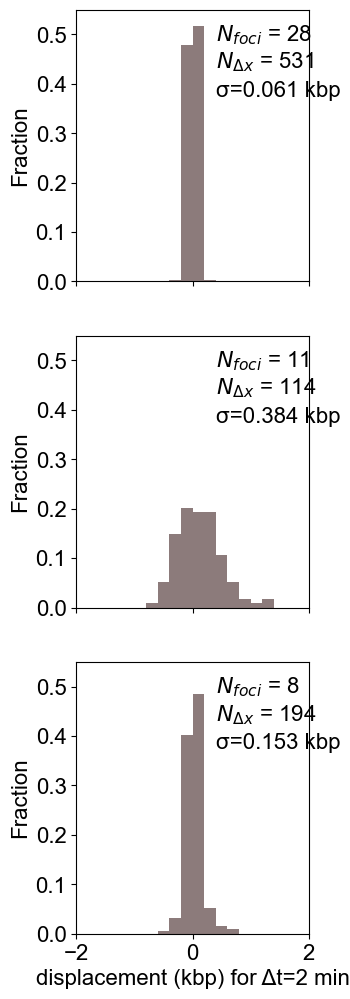

In [9]:
font = {'family':'arial', 'size'   : 16}
#linewidth = 4
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42


fig2_down = plt.figure(constrained_layout=True,figsize=(3, 12))
gs = fig2_down.add_gridspec(3, 1)

#dCas9
fig2_down_ax1 = fig2_down.add_subplot(gs[0])
#fig2_down_ax1.set_title('Exp4')

plt.hist(dx_arr_dCas9, bins=np.arange(-2, 2, 0.2), weights=[1/len(dx_arr_dCas9) for _ in dx_arr_dCas9],color='#8c7b7b')

plt.xlim((-2, 2))
plt.ylim((0, 0.55))
#plt.xlabel('displacement (kbp)')
fig2_down_ax1.set_xticklabels([])
fig2_down_ax1.set_xticklabels([])

plt.ylabel('Fraction')
plt.annotate("$N_{foci}$ = " + str(datar0dCas9['n_traces']), xy=(0.6, 0.95),
                 xycoords='axes fraction', horizontalalignment='left', verticalalignment='top', fontsize=16)
plt.annotate("$N_{Δx}$ = " + str(len(dx_arr_dCas9)), xy=(0.6, 0.85), 
             xycoords='axes fraction', horizontalalignment='left', verticalalignment='top', fontsize=16)
plt.annotate('σ=%.3f kbp' % np.std(dx_arr_dCas9), xy=(0.6, 0.74), 
            xycoords='axes fraction', horizontalalignment='left', verticalalignment='top', fontsize=16)






#Exp5bis
fig2_down_ax2 = fig2_down.add_subplot(gs[1])

plt.hist(dx_arr5bis, bins=np.arange(-2, 2, 0.2), weights=[1/len(dx_arr5bis) for _ in dx_arr5bis],color='#8c7b7b')

plt.xlim((-2, 2))
plt.ylim((0, 0.55))
#plt.xlabel('displacement (kbp)')
fig2_down_ax2.set_xticklabels([])
fig2_down_ax2.set_xticklabels([])
plt.ylabel('Fraction')
plt.annotate("$N_{foci}$ = " + str(datar05bis['n_traces']), xy=(0.6, 0.95),
                 xycoords='axes fraction', horizontalalignment='left', verticalalignment='top', fontsize=16)
plt.annotate("$N_{Δx}$ = " + str(len(dx_arr5bis)), xy=(0.6, 0.85), 
             xycoords='axes fraction', horizontalalignment='left', verticalalignment='top', fontsize=16)
plt.annotate('σ=%.3f kbp' % np.std(dx_arr5bis), xy=(0.6, 0.74), 
            xycoords='axes fraction', horizontalalignment='left', verticalalignment='top', fontsize=16)







#Exp3bis
fig2_down_ax3 = fig2_down.add_subplot(gs[2])

plt.hist(dx_arr3bis, bins=np.arange(-2, 2, 0.2), weights=[1/len(dx_arr3bis) for _ in dx_arr3bis],color='#8c7b7b')

plt.xlim((-2, 2))
plt.ylim((0, 0.55))
plt.xlabel('displacement (kbp) for Δt=2 min')
plt.ylabel('Fraction')

plt.annotate("$N_{foci}$ = " + str(datar0ori3bis['n_traces']), xy=(0.6, 0.95),
                 xycoords='axes fraction', horizontalalignment='left', verticalalignment='top', fontsize=16)
plt.annotate("$N_{Δx}$ = " + str(len(dx_arr3bis)), xy=(0.6, 0.85), 
            xycoords='axes fraction', horizontalalignment='left', verticalalignment='top', fontsize=16)
plt.annotate('σ=%.3f kbp' % np.std(dx_arr3bis), xy=(0.6, 0.74), 
            xycoords='axes fraction', horizontalalignment='left', verticalalignment='top', fontsize=16)






# Show graphic

gs.update(wspace=1)
plt.tight_layout()
plt.show()